In [17]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [18]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [19]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [20]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = True):
    # Read data and merge
    df = pd.read_csv('../input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('../input/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    
    # Categorical features: Binary features and One-Hot encoding
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    del test_df
    gc.collect()
    return df

In [21]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(columns= 'SK_ID_BUREAU', inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
        'AMT_ANNUITY': ['max', 'mean'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACT_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLS_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


In [22]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APR_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REF_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [23]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [24]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(columns= 'SK_ID_BUREAU', inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
        'AMT_ANNUITY': ['max', 'mean'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACT_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLS_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [25]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [26]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(columns = ['SK_ID_PREV'], inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [27]:
from random import shuffle
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
#         rows = np.random.randint(2, size=train_y.size).astype('bool')
        print((train_y == 1).sum(), (train_y == 0).sum())
        train_x_1 = train_x[train_y == 1]
        train_x_0 = train_x[train_y == 0]
        train_y_1 = train_y[train_y == 1]
        train_y_0 = train_y[train_y == 0]
        
        train_x_0 = train_x_0.sample((train_y == 1).sum())
        train_y_0 = train_y_0.sample((train_y == 1).sum())
        print(train_y_1.shape, train_y_0.shape)
        balanced_train_x = pd.concat([train_x_1, train_x_0])
        balanced_train_y = pd.concat([train_y_1, train_y_0])
        print("1. Starting LightGBM. + shape: {}, - shape: {}".format((balanced_train_y == 1).sum(), (balanced_train_y == 0).sum()))
        
#         ind_list=[i for i in range(balanced_train_x.size)]
#         shuffle(ind_list)
#         balanced_train_x=balanced_train_x[ind_list,:]
#         balanced_train_y=balanced_train_y[ind_list,:]
        idx = np.random.permutation(balanced_train_y.index)
        balanced_train_x = balanced_train_x.reindex(idx)
        balanced_train_y = balanced_train_y.reindex(idx)
        print("2. Starting LightGBM. + shape: {}, - shape: {}".format((balanced_train_y == 1).sum(), (balanced_train_y == 0).sum()))
        
        print((valid_y == 1).sum(), (train_y == 0).sum())
        valid_x_1 = valid_x[valid_y == 1]
        valid_x_0 = valid_x[valid_y == 0]
        valid_y_1 = valid_y[valid_y == 1]
        valid_y_0 = valid_y[valid_y == 0]
        
        valid_x_0 = valid_x_0.sample((valid_y == 1).sum())
        valid_y_0 = valid_y_0.sample((valid_y == 1).sum())
        print(valid_y_1.shape, valid_y_0.shape)
        balanced_valid_x = pd.concat([valid_x_1, valid_x_0])
        balanced_valid_y = pd.concat([valid_y_1, valid_y_0])
        print("1. Starting LightGBM. + shape: {}, - shape: {}".format((balanced_valid_y == 1).sum(), (balanced_valid_y == 0).sum()))
        
#         ind_list=[i for i in range(balanced_train_x.size)]
#         shuffle(ind_list)
#         balanced_train_x=balanced_train_x[ind_list,:]
#         balanced_train_y=balanced_train_y[ind_list,:]
        idx = np.random.permutation(balanced_valid_y.index)
        balanced_valid_x = balanced_valid_x.reindex(idx)
        balanced_valid_y = balanced_valid_y.reindex(idx)
        print("2. Starting LightGBM. + shape: {}, - shape: {}".format((balanced_valid_y == 1).sum(), (balanced_valid_y == 0).sum()))
    
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(balanced_train_x, balanced_train_y, eval_set=[(balanced_train_x, balanced_train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 100)

        oof_preds_valid = clf.predict_proba(balanced_valid_x, num_iteration=clf.best_iteration_)[:, 1]
        # oof_preds[valid_idx]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(balanced_valid_y, oof_preds_valid)))
        print(average_precision_score(1-balanced_valid_y, 1-oof_preds_valid))
        valid_y_pred = clf.predict(balanced_valid_x)
        print(classification_report(balanced_valid_y, valid_y_pred))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    test_df['TARGET'] = sub_preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [28]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')

In [30]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 5, stratified = True)

if __name__ == "__main__":
    submission_file_name = "submission_kernel26.csv"
    with timer("Full model run"):
        main(debug= False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 122)
Process bureau and bureau_balance - done in 62s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 79s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 32s
Installments payments df shape: (339587, 26)
Process installments payments - done in 64s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 48s
Starting LightGBM. Train shape: (307511, 816), test shape: (48744, 816)
19860 226148
(19860,) (19860,)
1. Starting LightGBM. + shape: 19860, - shape: 19860
2. Starting LightGBM. + shape: 19860, - shape: 19860
4965 226148
(4965,) (4965,)
1. Starting LightGBM. + shape: 4965, - shape: 4965
2. Starting LightGBM. + shape: 4965, - shape: 4965
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.695815	training's binary_logloss: 0.678406	valid_1's auc: 0.499349	valid_1's binary_logloss: 0.694495
Early s

NameError: name 'classification_report' is not defined

In [35]:
train_df = df[df['TARGET'].notnull()]
train_df.shape

(307511, 260)

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import average_precision_score

def kfold_rf(df, num_folds, stratified = False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting RF. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        print(train_x.shape)
        

        clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=229)
    
#         train_x = pd.DataFrame(data=train_x[1:,1:],index=train_x[1:,0], columns=train_x[0,1:]) 
        
        print((train_y == 1).sum(), (train_y == 0).sum())
#         raise
        train_x_1 = train_x[train_y == 1]
        train_x_0 = train_x[train_y == 0]
        train_y_1 = train_y[train_y == 1]
        train_y_0 = train_y[train_y == 0]
        
        train_x_0 = train_x_0.sample((train_y == 1).sum())
        train_y_0 = train_y_0.sample((train_y == 1).sum())
        print(train_y_1.shape, train_y_0.shape)
        balanced_train_x = pd.concat([train_x_1, train_x_0])
        balanced_train_y = pd.concat([train_y_1, train_y_0])
        print("1. Starting LightGBM. + shape: {}, - shape: {}".format((balanced_train_y == 1).sum(), (balanced_train_y == 0).sum()))
        
#         ind_list=[i for i in range(balanced_train_x.size)]
#         shuffle(ind_list)
#         balanced_train_x=balanced_train_x[ind_list,:]
#         balanced_train_y=balanced_train_y[ind_list,:]
        idx = np.random.permutation(balanced_train_y.index)
        balanced_train_x = balanced_train_x.reindex(idx)
        balanced_train_y = balanced_train_y.reindex(idx)
        print("2. Starting LightGBM. + shape: {}, - shape: {}".format((balanced_train_y == 1).sum(), (balanced_train_y == 0).sum()))
        
        balanced_train_x = balanced_train_x.replace([np.inf, -np.inf], np.nan)
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp = imp.fit(balanced_train_x)
        balanced_train_x = imp.transform(balanced_train_x)
        
#         clf.fit(balanced_train_x, balanced_train_y)
        train_x = train_x.replace([np.inf, -np.inf], np.nan)
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp = imp.fit(train_x)
        train_x = imp.transform(train_x)
        clf.fit(train_x, train_y)

        print((valid_y == 1).sum(), (train_y == 0).sum())
        valid_x_1 = valid_x[valid_y == 1]
        valid_x_0 = valid_x[valid_y == 0]
        valid_y_1 = valid_y[valid_y == 1]
        valid_y_0 = valid_y[valid_y == 0]
        
        valid_x_0 = valid_x_0.sample((valid_y == 1).sum())
        valid_y_0 = valid_y_0.sample((valid_y == 1).sum())
        print(valid_y_1.shape, valid_y_0.shape)
        balanced_valid_x = pd.concat([valid_x_1, valid_x_0])
        balanced_valid_y = pd.concat([valid_y_1, valid_y_0])
        print("1. Starting LightGBM. + shape: {}, - shape: {}".format((balanced_valid_y == 1).sum(), (balanced_valid_y == 0).sum()))
        
#         ind_list=[i for i in range(balanced_train_x.size)]
#         shuffle(ind_list)
#         balanced_train_x=balanced_train_x[ind_list,:]
#         balanced_train_y=balanced_train_y[ind_list,:]
        idx = np.random.permutation(balanced_valid_y.index)
        balanced_valid_x = balanced_valid_x.reindex(idx)
        balanced_valid_y = balanced_valid_y.reindex(idx)
        print("2. Starting LightGBM. + shape: {}, - shape: {}".format((balanced_valid_y == 1).sum(), (balanced_valid_y == 0).sum()))
#         balanced_valid_x = valid_x
#         balanced_valid_y = valid_y
        balanced_valid_x = balanced_valid_x.replace([np.inf, -np.inf], np.nan)
        imp = imp.fit(balanced_valid_x)
        balanced_valid_x = imp.transform(balanced_valid_x)
        oof_preds_valid = clf.predict_proba(balanced_valid_x)[:, 1]
#         sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(balanced_valid_y, oof_preds_valid)))
#         print(average_precision_score(1-valid_y, 1-oof_preds_valid))
#         valid_y_pred = clf.predict(balanced_valid_x)
        valid_x = valid_x.replace([np.inf, -np.inf], np.nan)
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp = imp.fit(valid_x)
        valid_x = imp.transform(valid_x)
        valid_y_pred = clf.predict(valid_x)
    
#         print(classification_report(balanced_valid_y, valid_y_pred))
        print(classification_report(valid_y, valid_y_pred))
#         del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    test_df['TARGET'] = sub_preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [37]:
num_rows = None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()


Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 122)
Process bureau and bureau_balance - done in 63s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 79s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 36s
Installments payments df shape: (339587, 26)
Process installments payments - done in 67s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 44s


In [39]:
df.shape
df.to_numpy()

array([[0.0000000e+00, 2.4700500e+04, 4.0659750e+05, ...,           nan,
                  nan,           nan],
       [1.0000000e+00, 3.5698500e+04, 1.2935025e+06, ...,           nan,
                  nan,           nan],
       [2.0000000e+00, 6.7500000e+03, 1.3500000e+05, ...,           nan,
                  nan,           nan],
       ...,
       [4.8741000e+04, 3.3205500e+04, 3.1500000e+05, ...,           nan,
                  nan,           nan],
       [4.8742000e+04, 2.5128000e+04, 4.5000000e+05, ...,           nan,
                  nan,           nan],
       [4.8743000e+04, 2.4709500e+04, 3.1276800e+05, ..., 0.0000000e+00,
        0.0000000e+00, 1.2000000e+01]])

Starting LightGBM. Train shape: (307511, 816), test shape: (48744, 816)
19860 226148
(19860,) (19860,)
1. Starting LightGBM. + shape: 19860, - shape: 19860
2. Starting LightGBM. + shape: 19860, - shape: 19860
4965 226148
(4965,) (4965,)
1. Starting LightGBM. + shape: 4965, - shape: 4965
2. Starting LightGBM. + shape: 4965, - shape: 4965
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.684845	training's binary_logloss: 0.679946	valid_1's auc: 0.521243	valid_1's binary_logloss: 0.692396
Early stopping, best iteration is:
[66]	training's auc: 0.662137	training's binary_logloss: 0.683949	valid_1's auc: 0.521756	valid_1's binary_logloss: 0.692249
Fold  1 AUC : 0.501572
0.5031106111377783
              precision    recall  f1-score   support

         0.0       0.50      0.73      0.60      4965
         1.0       0.51      0.27      0.36      4965

    accuracy                           0.50      9930
   macro avg       0.51      0.50      0.48      9930

/Users/xiaomengjin/miniconda3/envs/cs229/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Run lightGBM with kfold - done in 68s


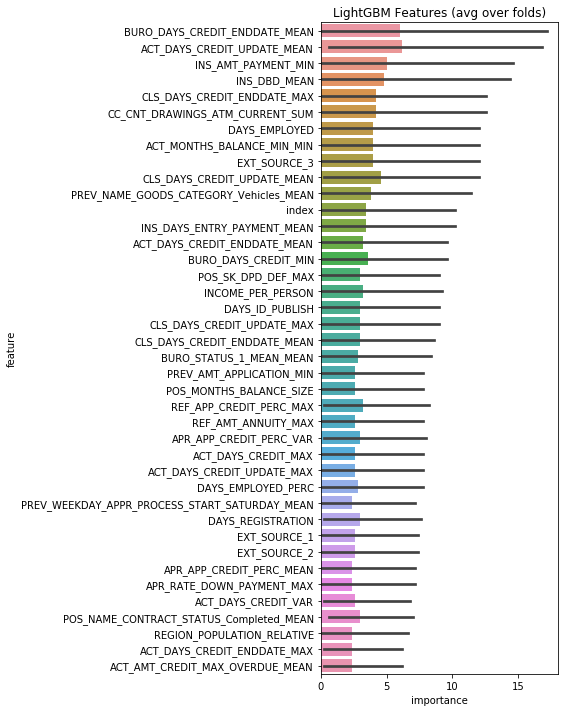

In [44]:
with timer("Run lightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified = True)

Starting RF. Train shape: (307511, 816), test shape: (48744, 816)
(246008, 814)
19860 226148
(19860,) (19860,)
1. Starting LightGBM. + shape: 19860, - shape: 19860
2. Starting LightGBM. + shape: 19860, - shape: 19860
4965 226148
(4965,) (4965,)
1. Starting LightGBM. + shape: 4965, - shape: 4965
2. Starting LightGBM. + shape: 4965, - shape: 4965
Fold  1 AUC : 0.503200


/Users/xiaomengjin/miniconda3/envs/cs229/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

(246009, 814)
19860 226149
(19860,) (19860,)
1. Starting LightGBM. + shape: 19860, - shape: 19860
2. Starting LightGBM. + shape: 19860, - shape: 19860
4965 226149
(4965,) (4965,)
1. Starting LightGBM. + shape: 4965, - shape: 4965
2. Starting LightGBM. + shape: 4965, - shape: 4965
Fold  2 AUC : 0.506473


/Users/xiaomengjin/miniconda3/envs/cs229/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502

(246009, 814)
19860 226149
(19860,) (19860,)
1. Starting LightGBM. + shape: 19860, - shape: 19860
2. Starting LightGBM. + shape: 19860, - shape: 19860
4965 226149
(4965,) (4965,)
1. Starting LightGBM. + shape: 4965, - shape: 4965
2. Starting LightGBM. + shape: 4965, - shape: 4965
Fold  3 AUC : 0.504723


/Users/xiaomengjin/miniconda3/envs/cs229/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502

(246009, 814)
19860 226149
(19860,) (19860,)
1. Starting LightGBM. + shape: 19860, - shape: 19860
2. Starting LightGBM. + shape: 19860, - shape: 19860
4965 226149
(4965,) (4965,)
1. Starting LightGBM. + shape: 4965, - shape: 4965
2. Starting LightGBM. + shape: 4965, - shape: 4965
Fold  4 AUC : 0.504913


/Users/xiaomengjin/miniconda3/envs/cs229/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502

(246009, 814)
19860 226149
(19860,) (19860,)
1. Starting LightGBM. + shape: 19860, - shape: 19860
2. Starting LightGBM. + shape: 19860, - shape: 19860
4965 226149
(4965,) (4965,)
1. Starting LightGBM. + shape: 4965, - shape: 4965
2. Starting LightGBM. + shape: 4965, - shape: 4965
Fold  5 AUC : 0.501844


/Users/xiaomengjin/miniconda3/envs/cs229/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502

Full AUC score 0.500000


/Users/xiaomengjin/miniconda3/envs/cs229/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Run RF with kfold - done in 310s


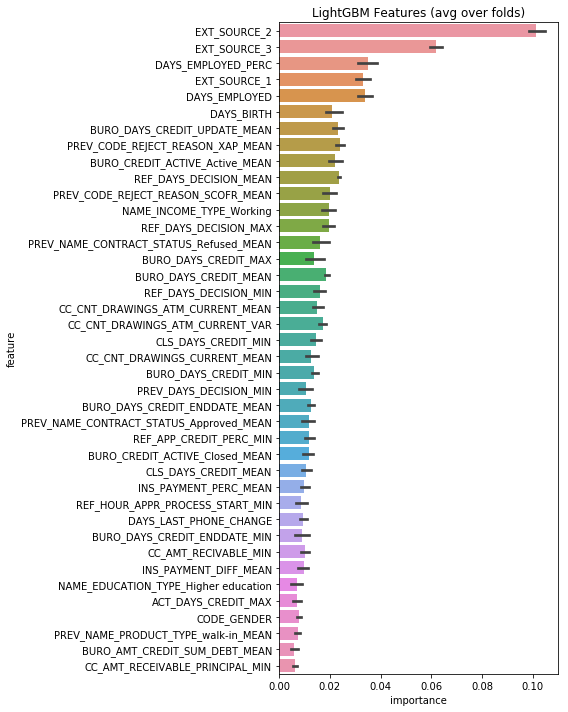

In [51]:
from sklearn.metrics import classification_report

with timer("Run RF with kfold"):
    feat_importance = kfold_rf(df, num_folds= 5, stratified = True)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def kfold_lr(df, num_folds, stratified = False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LR. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = LogisticRegression(random_state=229, solver='liblinear', max_iter=10000)
    
        print((train_y == 1).sum(), (train_y == 0).sum())
        train_x_1 = train_x[train_y == 1]
        train_x_0 = train_x[train_y == 0]
        train_y_1 = train_y[train_y == 1]
        train_y_0 = train_y[train_y == 0]
        
        train_x_0 = train_x_0.sample((train_y == 1).sum())
        train_y_0 = train_y_0.sample((train_y == 1).sum())
        print(train_y_1.shape, train_y_0.shape)
        balanced_train_x = pd.concat([train_x_1, train_x_0])
        balanced_train_y = pd.concat([train_y_1, train_y_0])
        print("1. Starting LR. + shape: {}, - shape: {}".format((balanced_train_y == 1).sum(), (balanced_train_y == 0).sum()))
        
#         ind_list=[i for i in range(balanced_train_x.size)]
#         shuffle(ind_list)
#         balanced_train_x=balanced_train_x[ind_list,:]
#         balanced_train_y=balanced_train_y[ind_list,:]
        idx = np.random.permutation(balanced_train_y.index)
        balanced_train_x = balanced_train_x.reindex(idx)
        balanced_train_y = balanced_train_y.reindex(idx)
        print("2. Starting LR. + shape: {}, - shape: {}".format((balanced_train_y == 1).sum(), (balanced_train_y == 0).sum()))
        
        balanced_train_x = balanced_train_x.replace([np.inf, -np.inf], np.nan)
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp = imp.fit(balanced_train_x)
        balanced_train_x = imp.transform(balanced_train_x)
        print(1)
        clf.fit(balanced_train_x, balanced_train_y)
        print(2)

        valid_x = valid_x.replace([np.inf, -np.inf], np.nan)
        imp = imp.fit(valid_x)
        valid_x_imp = imp.transform(valid_x)
        oof_preds[valid_idx] = clf.predict_proba(valid_x_imp)[:, 1]
#         sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
#         fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
#         feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        print(average_precision_score(valid_y, oof_preds[valid_idx]))
        valid_y_pred = clf.predict(valid_x_imp)
        print(classification_report(valid_y, valid_y_pred))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    test_df['TARGET'] = sub_preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [ ]:
with timer("Run LR with kfold"):
    feat_importance = kfold_lr(df, num_folds= 5, stratified = True)

Starting LR. Train shape: (307511, 816), test shape: (48744, 816)
19860 226148
(19860,) (19860,)
1. Starting LR. + shape: 19860, - shape: 19860
2. Starting LR. + shape: 19860, - shape: 19860
1
2
Fold  1 AUC : 0.645861
              precision    recall  f1-score   support

         0.0       0.94      0.80      0.87     56538
         1.0       0.14      0.37      0.21      4965

    accuracy                           0.77     61503
   macro avg       0.54      0.59      0.54     61503
weighted avg       0.87      0.77      0.81     61503

19860 226149
(19860,) (19860,)
1. Starting LR. + shape: 19860, - shape: 19860
2. Starting LR. + shape: 19860, - shape: 19860
1
2
Fold  2 AUC : 0.640993
              precision    recall  f1-score   support

         0.0       0.93      0.81      0.87     56537
         1.0       0.14      0.35      0.20      4965

    accuracy                           0.78     61502
   macro avg       0.54      0.58      0.54     61502
weighted avg       0.87      0.